Read dimensions from shape file: depth=83, rows=512, cols=512
Read data size: 21757952
Max difference: 2412.0
Mean difference: 157.65721130371094


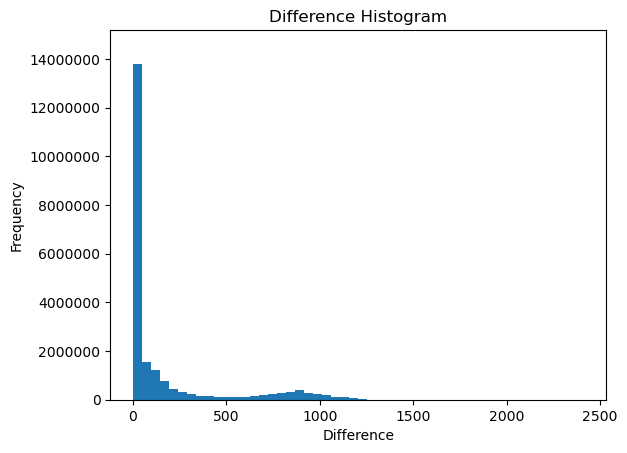

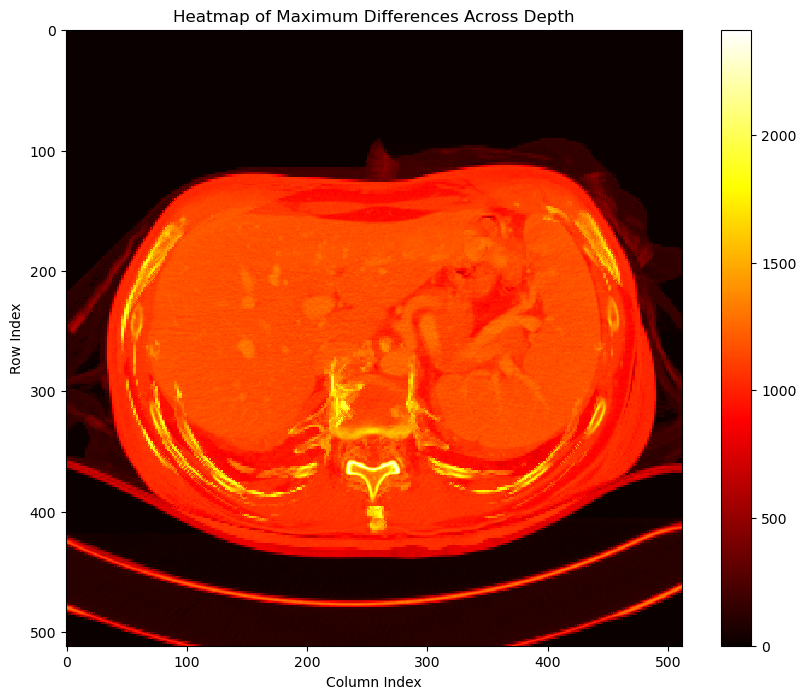

In [13]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import os

def read_shape_file(shape_filename):
    with open(shape_filename, 'r') as f:
        shape = tuple(map(int, f.read().strip().split(',')))
    return shape

def read_binary_file(filename, shape_filename):
    depth, rows, cols = read_shape_file(shape_filename)
    print(f"Read dimensions from shape file: depth={depth}, rows={rows}, cols={cols}")
    
    with open(filename, 'rb') as file:
        data = np.fromfile(file, dtype=np.float32)
        print(f"Read data size: {data.size}")
        
        data = data.reshape((depth, rows, cols))
    return data

def write_wavelet3d_result(filename, coeffs):
    with open(filename, 'wb') as file:
        for key in coeffs:
            data = coeffs[key]
            depth, rows, cols = data.shape
            file.write(np.array([depth, rows, cols], dtype=np.uint64).tobytes())
            file.write(data.astype(np.float32).tobytes())

def read_wavelet3d_result(filename):
    subbands = {}
    key_map = {
        'aaa': 'LLL', 'aad': 'LLH', 'ada': 'LHL', 'add': 'LHH',
        'daa': 'HLL', 'dad': 'HLH', 'dda': 'HHL', 'ddd': 'HHH'
    }
    with open(filename, 'rb') as file:
        for key in key_map:
            depth = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            rows = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            cols = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            data = np.fromfile(file, dtype=np.float32, count=depth*rows*cols)
            data = data.reshape((depth, rows, cols))
            subbands[key] = data
    return subbands

def crop_data(data, target_shape):
    slices = tuple(slice(0, min(s, t)) for s, t in zip(data.shape, target_shape))
    return data[slices]

def compare_data(original, reconstructed):
    difference = np.abs(original - reconstructed)
    max_diff = np.max(difference)
    mean_diff = np.mean(difference)
    print(f"Max difference: {max_diff}")
    print(f"Mean difference: {mean_diff}")
    
    # Plot the histogram of differences
    plt.hist(difference.flatten(), bins=50, range=(0, max_diff))
    plt.title('Difference Histogram')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    
    # Adjust the y-axis limit to make the scale more readable
    y_max = np.max(np.histogram(difference.flatten(), bins=50)[0]) * 1.1
    plt.ylim(0, y_max)
    
    # Set y-axis tick labels to show full values without scientific notation
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    plt.show()
    
    return difference

def visualize_differences(difference):
    plt.figure(figsize=(10, 8))
    plt.imshow(difference.max(axis=0), cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Heatmap of Maximum Differences Across Depth')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

# Read the results from the C++ implementation
cpp_filename = '../../Final/serial/outputs/11out.bin'
data_cpp = read_wavelet3d_result(cpp_filename)

# Perform the inverse 3D DWT
reconstructed_data_cpp = pywt.idwtn(data_cpp, 'db1', axes=(0, 1, 2))

# Read the original input data
original_filename = '../../Final/data/11/11.bin'
shape_filename = '../../Final/data/11/11_shape.txt'
original_data = read_binary_file(original_filename, shape_filename)

# Crop the reconstructed data to match the shape of the original data
target_shape = original_data.shape
reconstructed_data_cpp_cropped = crop_data(reconstructed_data_cpp, target_shape)

# Compare the original data with the cropped reconstructed data from C++ implementation
difference = compare_data(original_data, reconstructed_data_cpp_cropped)

# Visualize the differences
visualize_differences(difference)